In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-consumption-20152020/GercekZamanliTuketim-01072015-30062020.csv


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
pd.options.display.float_format = '{:.2f}'.format
import matplotlib,numpy,pandas,keras,sys
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout,Flatten
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib import dates
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("keras", keras.__version__),
           ("plotly",plotly.__version__))

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
[GCC 7.3.0] 

library    version
------------------
matplotlib  3.2.1
numpy       1.18.5
pandas      1.0.3
keras       2.4.3
plotly      4.8.2


In [4]:
data=pd.read_csv("/kaggle/input/electricity-consumption-20152020/GercekZamanliTuketim-01072015-30062020.csv",encoding= 'unicode_escape')
df=data.copy()
df.head()

,Tarih,Saat,Tüketim Miktarý (MWh)
0,31.12.2015,00:00,"29.590,88"
1,31.12.2015,01:00,"27.785,43"
2,31.12.2015,02:00,"26.516,53"
3,31.12.2015,03:00,"26.091,62"
4,31.12.2015,04:00,"25.871,54"


In [5]:
df.shape

(39456, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39456 entries, 0 to 39455
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tarih                  39456 non-null  object
 1   Saat                   39456 non-null  object
 2   Tüketim Miktarý (MWh)  39456 non-null  object
dtypes: object(3)
memory usage: 924.9+ KB


In [7]:
df=df.rename({"Tüketim Miktarý (MWh)":"tuketim"},axis=1)
df.head()

,Tarih,Saat,tuketim
0,31.12.2015,00:00,"29.590,88"
1,31.12.2015,01:00,"27.785,43"
2,31.12.2015,02:00,"26.516,53"
3,31.12.2015,03:00,"26.091,62"
4,31.12.2015,04:00,"25.871,54"


In [8]:
df.Tarih=[i.replace(".","-") for i in df.Tarih]
    

In [9]:
df.head()

,Tarih,Saat,tuketim
0,31-12-2015,00:00,"29.590,88"
1,31-12-2015,01:00,"27.785,43"
2,31-12-2015,02:00,"26.516,53"
3,31-12-2015,03:00,"26.091,62"
4,31-12-2015,04:00,"25.871,54"


In [10]:
df.Tarih=df["Tarih"]+" "+df["Saat"]

In [11]:

df.Tarih=pd.to_datetime(df.Tarih,format="%d-%m-%Y %H:%M")

In [12]:
df.head()

,Tarih,Saat,tuketim
0,2015-12-31 00:00:00,00:00,"29.590,88"
1,2015-12-31 01:00:00,01:00,"27.785,43"
2,2015-12-31 02:00:00,02:00,"26.516,53"
3,2015-12-31 03:00:00,03:00,"26.091,62"
4,2015-12-31 04:00:00,04:00,"25.871,54"


In [13]:
df.tuketim=df.tuketim.str.replace(" ","")

In [14]:
df.tuketim=df.tuketim.str.replace(".","")
df.tuketim=df.tuketim.str.replace(",",".")


In [15]:
df.tuketim=df.tuketim.astype(float)

In [16]:
df.dtypes

Tarih      datetime64[ns]
Saat               object
tuketim           float64
dtype: object

In [17]:
df=df.set_index("Tarih")

In [18]:
df.head()

,Saat,tuketim
Tarih,,
2015-12-31 00:00:00,00:00,29590.88
2015-12-31 01:00:00,01:00,27785.43
2015-12-31 02:00:00,02:00,26516.53
2015-12-31 03:00:00,03:00,26091.62
2015-12-31 04:00:00,04:00,25871.54


In [19]:
df.isnull().sum()

Saat       0
tuketim    0
dtype: int64

In [20]:
df.eq(0).sum()

Saat       0
tuketim    1
dtype: int64

In [21]:
df[df.tuketim==0]=np.nan
df.tuketim=df.tuketim.interpolate()

In [22]:
df.head()

,Saat,tuketim
Tarih,,
2015-12-31 00:00:00,00:00,29590.88
2015-12-31 01:00:00,01:00,27785.43
2015-12-31 02:00:00,02:00,26516.53
2015-12-31 03:00:00,03:00,26091.62
2015-12-31 04:00:00,04:00,25871.54


In [23]:
df.index.min(),df.index.max()

(Timestamp('2015-12-31 00:00:00'), Timestamp('2020-06-30 23:00:00'))

In [24]:
df.describe()

,tuketim
count,39456.00
mean,32534.18
std,5004.58
min,15333.30
25%,28624.27
50%,32719.71
75%,36082.97
max,47062.40


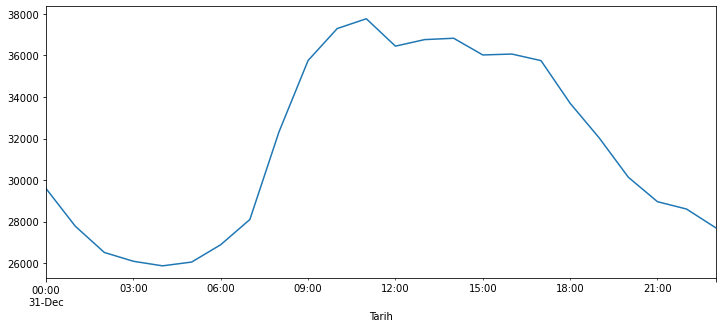

In [25]:
df["tuketim"]["2015-12"].plot(figsize=(12,5));

In [26]:
fig = px.line(df, y='tuketim',title="Electricity Consumption")
fig.show()

In [27]:
fig = px.line(df["tuketim"]["2016"], y='tuketim',title="Electricity Consumption")
fig.show()

In [28]:
fig = px.line(df["tuketim"]["2017"], y='tuketim',title="Electricity Consumption")
fig.show()

In [29]:
fig = px.line(df["tuketim"]["2018"], y='tuketim',title="Electricity Consumption")
fig.show()

In [30]:
fig = px.line(df["tuketim"]["2019"], y='tuketim',title="Electricity Consumption")
fig.show()

In [31]:
fig = px.line(df["tuketim"]["2020"], y='tuketim',title="Electricity Consumption")
fig.show()

In [32]:
df.head()

,Saat,tuketim
Tarih,,
2015-12-31 00:00:00,00:00,29590.88
2015-12-31 01:00:00,01:00,27785.43
2015-12-31 02:00:00,02:00,26516.53
2015-12-31 03:00:00,03:00,26091.62
2015-12-31 04:00:00,04:00,25871.54


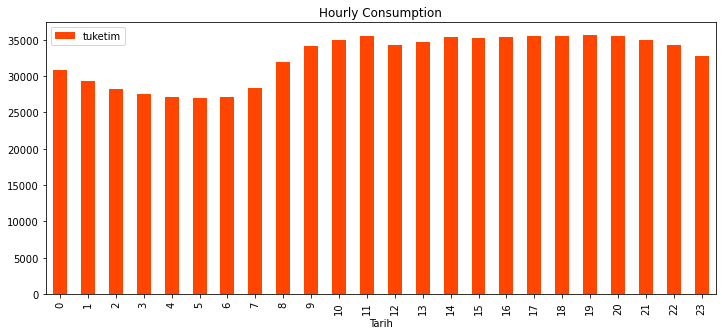

In [33]:
df.groupby(df.index.hour).mean().plot.bar(figsize=(12,5),color="orangered",title="Hourly Consumption");

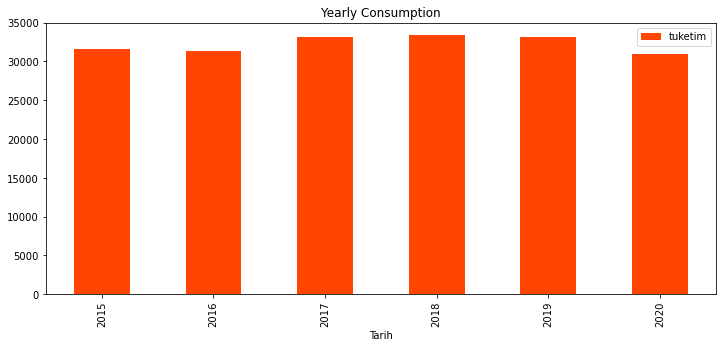

In [34]:
df.groupby(df.index.year).mean().plot.bar(figsize=(12,5),color="orangered",title="Yearly Consumption");

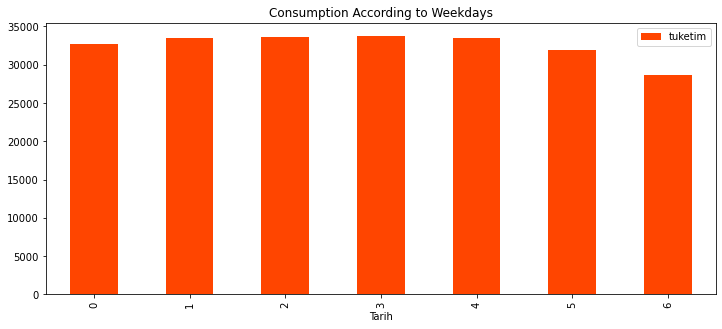

In [35]:
df.groupby(df.index.weekday).mean().plot.bar(figsize=(12,5),color="orangered",title="Consumption According to Weekdays");

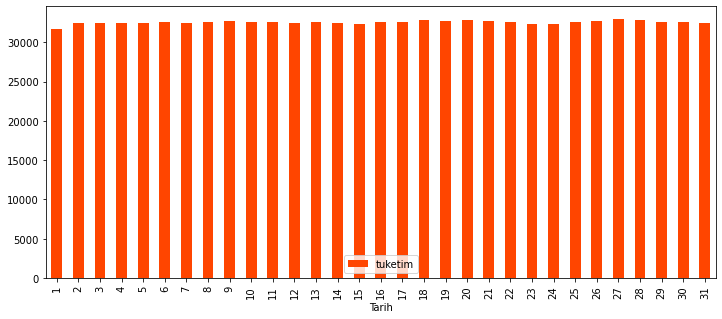

In [36]:
df.groupby(df.index.day).mean().plot.bar(figsize=(12,5),color="orangered");

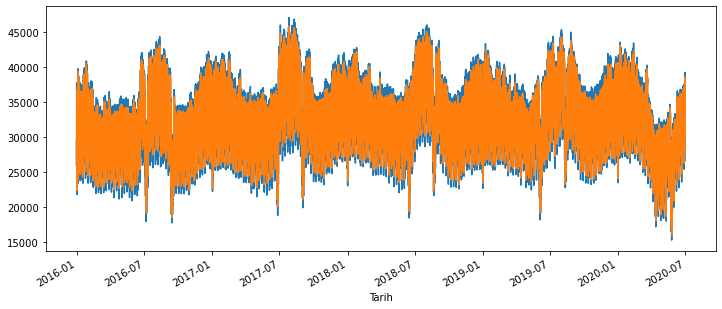

In [37]:
df.tuketim.plot(figsize=(12,5));
df.rolling(window=7).mean()["tuketim"].plot(figsize=(12,5));

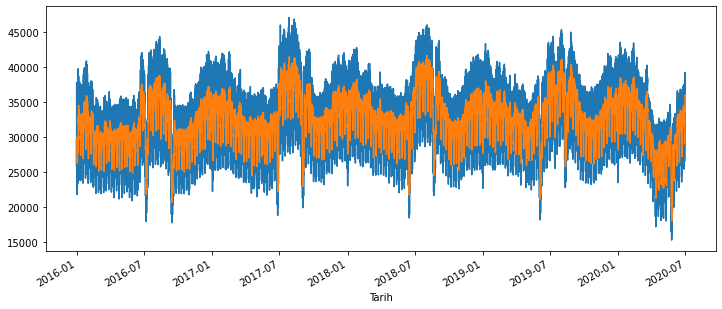

In [38]:
df.tuketim.plot(figsize=(12,5));
df.rolling(window=30).mean()["tuketim"].plot(figsize=(12,5)); 

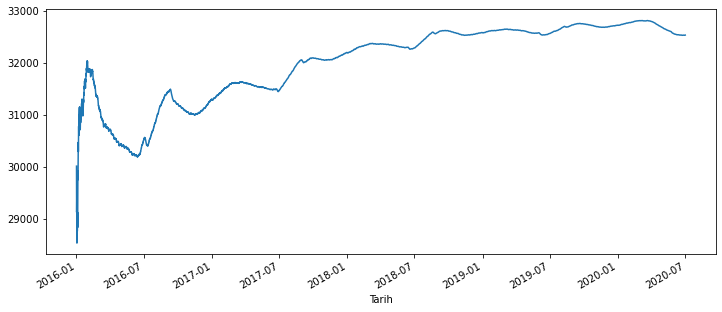

In [39]:
df.tuketim.expanding(30).mean().plot(figsize=(12,5));

In [40]:
df=df.drop("Saat",axis=1)

In [41]:
df.head()

,tuketim
Tarih,
2015-12-31 00:00:00,29590.88
2015-12-31 01:00:00,27785.43
2015-12-31 02:00:00,26516.53
2015-12-31 03:00:00,26091.62
2015-12-31 04:00:00,25871.54


In [42]:
df.resample("D").mean()[:10]

,tuketim
Tarih,
2015-12-31,31628.51
2016-01-01,27028.72
2016-01-02,29275.35
2016-01-03,28560.54
2016-01-04,33121.03
2016-01-05,33197.91
2016-01-06,32634.51
2016-01-07,32534.77
2016-01-08,32314.02


In [43]:
df.resample("D").sum()[:10]

,tuketim
Tarih,
2015-12-31,759084.33
2016-01-01,648689.21
2016-01-02,702608.51
2016-01-03,685453.07
2016-01-04,794904.71
2016-01-05,796749.92
2016-01-06,783228.21
2016-01-07,780834.48
2016-01-08,775536.44


In [44]:
df.resample("M").mean()

,tuketim
Tarih,
2015-12-31,31628.51
2016-01-31,31896.24
2016-02-29,30392.48
2016-03-31,29820.78
2016-04-30,29585.87
2016-05-31,29435.89
2016-06-30,32015.62
2016-07-31,32755.14
2016-08-31,35307.52


In [45]:
train=df.iloc[:-24]
test=df.tail(24)

train.shape,test.shape

((39432, 1), (24, 1))

In [46]:

scaler=MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [47]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=3)

In [48]:

model = Sequential()
model.add(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.01))
model.add(LSTM(50,activation="tanh",return_sequences=False))
#model.add(Dropout(0.1))
#model.add(LSTM(200,activation="relu",return_sequences=True))
#model.add(Dropout(0.1))
#model.add(LSTM(50,activation="tanh",return_sequences=False))
model.add(Dense(1))
model.compile(optimizer="Adam", loss='mse')

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 200)           161600    
_________________________________________________________________
dropout (Dropout)            (None, 24, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 211,851
Trainable params: 211,851
Non-trainable params: 0
_________________________________________________________________


In [50]:


monitor_val_acc = EarlyStopping(monitor="mse", patience=2)
model.fit_generator(generator,epochs=7,callbacks= [monitor_val_acc])

Epoch 1/7
13136/13136 [==============================] - 579s 44ms/step - loss: 0.0020
Epoch 2/7
13136/13136 [==============================] - 591s 45ms/step - loss: 7.0334e-04
Epoch 3/7
13136/13136 [==============================] - 579s 44ms/step - loss: 5.5872e-04
Epoch 4/7
13136/13136 [==============================] - 581s 44ms/step - loss: 4.5190e-04
Epoch 5/7
13136/13136 [==============================] - 607s 46ms/step - loss: 3.8753e-04
Epoch 6/7
13136/13136 [==============================] - 590s 45ms/step - loss: 3.5071e-04
Epoch 7/7
13136/13136 [==============================] - 583s 44ms/step - loss: 3.1357e-04


In [51]:
model.history.history.keys()

dict_keys(['loss'])

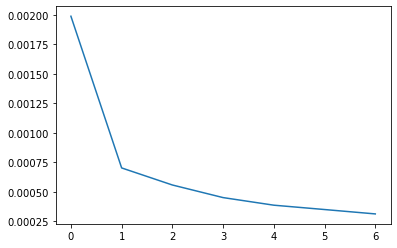

In [52]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch);

In [53]:
first_eval_batch = scaled_train[-24:]

In [54]:
first_eval_batch

array([[0.50938854],
       [0.46146597],
       [0.42572434],
       [0.39508212],
       [0.38365192],
       [0.35703502],
       [0.35446231],
       [0.4073513 ],
       [0.53098449],
       [0.63638773],
       [0.66254542],
       [0.69332695],
       [0.66051164],
       [0.68768197],
       [0.72979316],
       [0.73289063],
       [0.7462298 ],
       [0.75022014],
       [0.7183702 ],
       [0.70600301],
       [0.73117139],
       [0.74192713],
       [0.71290046],
       [0.66238815]])

In [55]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [56]:
first_eval_batch.shape

(1, 24, 1)

In [57]:
model.predict(first_eval_batch)


array([[0.604441]], dtype=float32)

In [58]:
scaled_test[0]

array([0.60260644])

In [59]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [60]:
current_batch

array([[[0.50938854],
        [0.46146597],
        [0.42572434],
        [0.39508212],
        [0.38365192],
        [0.35703502],
        [0.35446231],
        [0.4073513 ],
        [0.53098449],
        [0.63638773],
        [0.66254542],
        [0.69332695],
        [0.66051164],
        [0.68768197],
        [0.72979316],
        [0.73289063],
        [0.7462298 ],
        [0.75022014],
        [0.7183702 ],
        [0.70600301],
        [0.73117139],
        [0.74192713],
        [0.71290046],
        [0.66238815]]])

In [61]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [62]:
current_pred

array([0.61386377], dtype=float32)

In [63]:
current_batch

array([[[0.60444099],
        [0.54521447],
        [0.49973372],
        [0.46740508],
        [0.44761431],
        [0.43096146],
        [0.42482227],
        [0.45533767],
        [0.53764856],
        [0.64434493],
        [0.68426859],
        [0.6870904 ],
        [0.66253841],
        [0.63238913],
        [0.63911831],
        [0.64235961],
        [0.64368033],
        [0.65126318],
        [0.65990514],
        [0.67957282],
        [0.69595999],
        [0.68370831],
        [0.65307522],
        [0.61386377]]])

In [64]:
test_predictions

[array([0.604441], dtype=float32),
 array([0.5452145], dtype=float32),
 array([0.49973372], dtype=float32),
 array([0.46740508], dtype=float32),
 array([0.4476143], dtype=float32),
 array([0.43096146], dtype=float32),
 array([0.42482227], dtype=float32),
 array([0.45533767], dtype=float32),
 array([0.53764856], dtype=float32),
 array([0.6443449], dtype=float32),
 array([0.6842686], dtype=float32),
 array([0.6870904], dtype=float32),
 array([0.6625384], dtype=float32),
 array([0.6323891], dtype=float32),
 array([0.6391183], dtype=float32),
 array([0.6423596], dtype=float32),
 array([0.64368033], dtype=float32),
 array([0.6512632], dtype=float32),
 array([0.65990514], dtype=float32),
 array([0.6795728], dtype=float32),
 array([0.69596], dtype=float32),
 array([0.6837083], dtype=float32),
 array([0.6530752], dtype=float32),
 array([0.61386377], dtype=float32)]

In [65]:
#scaled_test

In [66]:
true_predictions = scaler.inverse_transform(test_predictions)

In [67]:
test['Predictions'] = true_predictions

In [68]:
test

,tuketim,Predictions
Tarih,,
2020-06-30 00:00:00,34453.46,34511.67
2020-06-30 01:00:00,32325.20,32632.46
2020-06-30 02:00:00,31610.04,31189.40
2020-06-30 03:00:00,30571.58,30163.64
2020-06-30 04:00:00,29949.92,29535.70
2020-06-30 05:00:00,28998.57,29007.32
2020-06-30 06:00:00,28924.08,28812.53
2020-06-30 07:00:00,30112.18,29780.75
2020-06-30 08:00:00,34151.38,32392.40


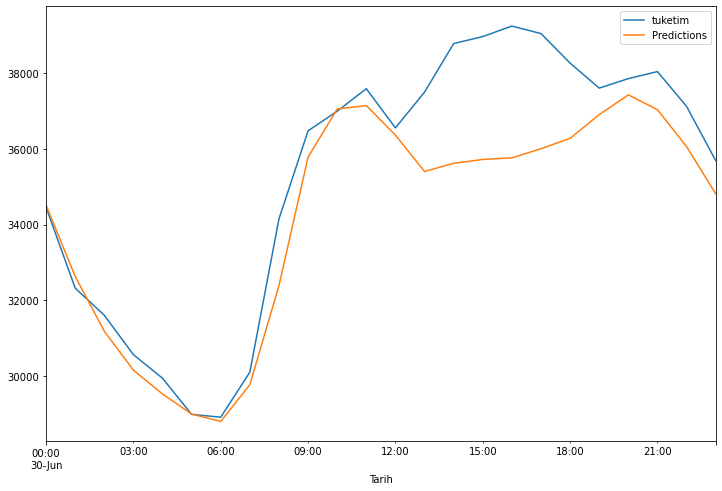

In [69]:
test.plot(figsize=(12,8));

In [70]:
from statsmodels.tools.eval_measures import mse,rmse

mse(test["tuketim"],test["Predictions"])

2420803.3097016662

In [71]:
rmse(test["tuketim"],test["Predictions"])

1555.8930907043923